# This notebook is for course four : Classification Analysis (Supervised Learning)

### Importing Data Files

In [1]:
#Import Product DataSet here
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_0a12b0a9bb954a7caf20a184ba345123 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='04LXucQ0Orzy-z3cr5nhbor5zaZZUOTuCl8eaAQlsY03',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_0a12b0a9bb954a7caf20a184ba345123.get_object(Bucket='project1-donotdelete-pr-bwj2jbipkjg71j',Key='Product Data Set - Student 2 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

product_data = pd.read_csv(body,sep='|')
product_data.head()

,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE
0,30001,HEALTH & BEAUTY,$7.45
1,30002,HEALTH & BEAUTY,$5.35
2,30003,HEALTH & BEAUTY,$5.49
3,30004,HEALTH & BEAUTY,$6.46
4,30005,HEALTH & BEAUTY,$7.33


In [2]:
#Import Transaction DataSet Here
body = client_0a12b0a9bb954a7caf20a184ba345123.get_object(Bucket='project1-donotdelete-pr-bwj2jbipkjg71j',Key='Transaction Data Set - Student 3 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

transactions_data = pd.read_csv(body,sep='|')
transactions_data.head()

,CUSTOMER NUM,PRODUCT NUM,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT
0,10114,30011,4,0.0,1/2/2015,0
1,10217,30016,3,0.0,1/2/2015,0
2,10224,30013,4,0.0,1/2/2015,0
3,10103,30012,3,0.2,1/2/2015,0
4,10037,30010,8,0.0,1/2/2015,0


In [3]:
#Import Customer Dataset Here
body = client_0a12b0a9bb954a7caf20a184ba345123.get_object(Bucket='project1-donotdelete-pr-bwj2jbipkjg71j',Key='Customer Data Set - Student 1 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

customer_data=pd.read_csv(body)
customer_data.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS
0,10001,0,64,"$133,498",5,enrolled,06-03-2013,4,Single
1,10002,0,42,"$94,475",9,notenrolled,NaN,6,Married
2,10003,0,40,"$88,610",9,enrolled,02-09-2010,5,Married
3,10004,0,38,"$84,313",8,enrolled,06-04-2015,1,Single
4,10005,0,30,"$51,498",3,notenrolled,NaN,1,Single


### Changing Data Types

In [4]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : x.replace('$',''))

In [5]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : int(x.replace(',','')))

### Creating Customer View

In [6]:
trans_products=transactions_data.merge(product_data,how='inner', left_on='PRODUCT NUM', right_on='PRODUCT CODE')

In [7]:
trans_products['UNIT LIST PRICE']=trans_products['UNIT LIST PRICE'].map(lambda x : float(x.replace('$','')))

In [8]:
trans_products['Total_Price']=trans_products['QUANTITY PURCHASED'] * trans_products['UNIT LIST PRICE'] * (1- trans_products['DISCOUNT TAKEN'])

In [9]:
customer_prod_categ=trans_products.groupby(['CUSTOMER NUM','PRODUCT CATEGORY']).agg({'Total_Price':'sum'})

In [10]:
customer_prod_categ=customer_prod_categ.reset_index()

In [11]:
customer_pivot=customer_prod_categ.pivot(index='CUSTOMER NUM',columns='PRODUCT CATEGORY',values='Total_Price')

In [12]:
trans_total_spend=trans_products.groupby('CUSTOMER NUM').agg({'Total_Price':'sum'}).\
rename(columns={'Total_Price':'TOTAL SPENT'})

In [13]:
customer_KPIs=customer_pivot.merge(trans_total_spend,how='inner',left_index=True, right_index=True )

In [14]:
customer_KPIs=customer_KPIs.fillna(0)


In [15]:
customer_all_view=customer_data.merge(customer_KPIs,how='inner', left_on='CUSTOMERID', right_index=True)

In [16]:
customer_all_view.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512


# Classification 

### Feature selection

In [17]:
DF_classification=customer_all_view[['INCOME','AGE','EXPERIENCE SCORE','TOTAL SPENT','LOYALTY GROUP']]
DF_classification.head(5)

,INCOME,AGE,EXPERIENCE SCORE,TOTAL SPENT,LOYALTY GROUP
0,133498,64,5,6826.770,enrolled
1,94475,42,9,5062.451,notenrolled
2,88610,40,9,8562.440,enrolled
3,84313,38,8,5522.694,enrolled
4,51498,30,3,213.512,notenrolled


In [18]:
target_feature = pd.DataFrame(DF_classification['LOYALTY GROUP'])
print(type(target_feature))
target_feature.head(5)

<class 'pandas.core.frame.DataFrame'>


,LOYALTY GROUP
0,enrolled
1,notenrolled
2,enrolled
3,enrolled
4,notenrolled


In [19]:
DF_classification = DF_classification.drop(['LOYALTY GROUP'],axis=1)
DF_classification.head(5)

,INCOME,AGE,EXPERIENCE SCORE,TOTAL SPENT
0,133498,64,5,6826.770
1,94475,42,9,5062.451
2,88610,40,9,8562.440
3,84313,38,8,5522.694
4,51498,30,3,213.512


In [20]:
from sklearn import preprocessing

In [21]:
DF_classification_column_names = DF_classification.columns.values

In [22]:
DF_classification=preprocessing.minmax_scale(DF_classification)

In [23]:
DF_classification=pd.DataFrame(DF_classification, columns=DF_classification_column_names)
DF_classification.head(5)

,INCOME,AGE,EXPERIENCE SCORE,TOTAL SPENT
0,0.872818,0.638889,0.444444,0.446532
1,0.572046,0.333333,0.888889,0.330790
2,0.526842,0.305556,0.888889,0.560394
3,0.493722,0.277778,0.777778,0.360983
4,0.240799,0.166667,0.222222,0.012694


In [24]:
DF_classification = pd.concat([DF_classification,target_feature], axis=1)
DF_classification.head(5)

,INCOME,AGE,EXPERIENCE SCORE,TOTAL SPENT,LOYALTY GROUP
0,0.872818,0.638889,0.444444,0.446532,enrolled
1,0.572046,0.333333,0.888889,0.330790,notenrolled
2,0.526842,0.305556,0.888889,0.560394,enrolled
3,0.493722,0.277778,0.777778,0.360983,enrolled
4,0.240799,0.166667,0.222222,0.012694,notenrolled


## Partitioning input data into training and testing splits

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train,X_test,Y_train,Y_test = \
train_test_split(DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']],DF_classification['LOYALTY GROUP'], test_size=0.2,random_state=42)

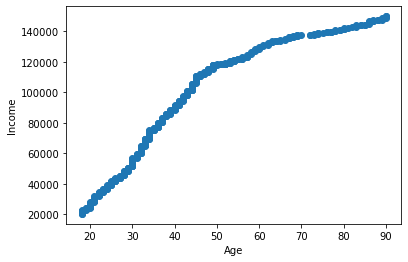

In [28]:
import matplotlib.pyplot as plt 
plt.scatter(customer_all_view['AGE'],customer_all_view['INCOME'])
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

# Training a K-Nearest Neighbor Classifier

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
clf_kNN = KNeighborsClassifier(n_neighbors=8)

In [31]:
clf_kNN

KNeighborsClassifier(n_neighbors=8)

In [32]:
clf_kNN.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=8)

In [33]:
type(X_train)

pandas.core.frame.DataFrame

In [34]:
predicted = clf_kNN.predict(X_test)

In [35]:
type(predicted)

numpy.ndarray

In [36]:
from sklearn import metrics

In [37]:
acc = metrics.accuracy_score(Y_test,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (metrics.classification_report(Y_test,predicted))

accuracy = 79.0%
              precision    recall  f1-score   support

    enrolled       0.73      0.92      0.82        51
 notenrolled       0.89      0.65      0.75        49

    accuracy                           0.79       100
   macro avg       0.81      0.79      0.79       100
weighted avg       0.81      0.79      0.79       100



# Training a Decision Trees Classifier

In [38]:
from sklearn.tree import DecisionTreeClassifier

In [39]:
clf_Tree=DecisionTreeClassifier(criterion='entropy', random_state=0) 

In [40]:
clf_Tree

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [41]:
clf_Tree.fit(X_train, Y_train)
predicted = clf_Tree .predict(X_test)
acc = metrics.accuracy_score(Y_test,predicted)
print ('accuracy = '+str(acc*100)+'%')
print (metrics.classification_report(Y_test,predicted))

accuracy = 75.0%
              precision    recall  f1-score   support

    enrolled       0.74      0.78      0.76        51
 notenrolled       0.76      0.71      0.74        49

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100



## Training and testing the model using k-fold cross-validation

In [42]:
from sklearn.model_selection import KFold

In [43]:
def Training_Testing_Accuracy_Only(model,train_data,train_labels,test_data,test_labels):
    model.fit(train_data,train_labels)
    predicted = model.predict(test_data)
    acc = metrics.accuracy_score(test_labels,predicted)
    print ('accuracy = '+str(acc*100)+'%')
    return(acc)

In [44]:
kf = KFold(n_splits=10)

### Training and testing the decision tree model by using 10-fold cross-validation

In [45]:
clf_Tree=DecisionTreeClassifier(criterion='entropy')
accuracy_list=[]

In [46]:
for train_index, test_index in kf.split(DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']]):
    X=DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']]
    Y=DF_classification['LOYALTY GROUP']
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    Y_train,Y_test=Y.iloc[train_index], Y.iloc[test_index]   
    accuracy=Training_Testing_Accuracy_Only(clf_Tree,X_train,Y_train,X_test,Y_test)
    accuracy_list.append(accuracy) 
print("overall_accuracy is %",100 * sum(accuracy_list)/len(accuracy_list))

accuracy = 78.0%
accuracy = 76.0%
accuracy = 74.0%
accuracy = 74.0%
accuracy = 72.0%
accuracy = 82.0%
accuracy = 70.0%
accuracy = 70.0%
accuracy = 72.0%
accuracy = 80.0%
overall_accuracy is % 74.8


### Training and testing the K-Nearest Neighbor classifier with a 10-fold cross-validation and finding the optimum K_neighbors

In [47]:
accuracy_list_for_each_K_neighbours=[]

In [48]:
for k_neighbours in range(1,15):
    clf_NN = KNeighborsClassifier(n_neighbors=k_neighbours)
    accuracy_list_k_fold = []
    for train_index, test_index in kf.split(DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']]):
        X=DF_classification[['EXPERIENCE SCORE','TOTAL SPENT','INCOME']]
        Y=DF_classification['LOYALTY GROUP']
        X_train,X_test=X.iloc[train_index], X.iloc[test_index]
        Y_train,Y_test=Y.iloc[train_index], Y.iloc[test_index]    
        accuracy=Training_Testing_Accuracy_Only(clf_NN,X_train,Y_train,X_test,Y_test)
        accuracy_list_k_fold.append(accuracy)
    accuracy_list_for_each_K_neighbours.append(100 * sum(accuracy_list_k_fold)/len(accuracy_list_k_fold))
    print("Overall Accuracy for K_neighbours=",k_neighbours,"is",accuracy_list_for_each_K_neighbours[k_neighbours-1])

accuracy = 64.0%
accuracy = 64.0%
accuracy = 66.0%
accuracy = 64.0%
accuracy = 82.0%
accuracy = 68.0%
accuracy = 70.0%
accuracy = 64.0%
accuracy = 76.0%
accuracy = 68.0%
Overall Accuracy for K_neighbours= 1 is 68.6
accuracy = 74.0%
accuracy = 60.0%
accuracy = 72.0%
accuracy = 74.0%
accuracy = 74.0%
accuracy = 78.0%
accuracy = 70.0%
accuracy = 72.0%
accuracy = 82.0%
accuracy = 76.0%
Overall Accuracy for K_neighbours= 2 is 73.2
accuracy = 72.0%
accuracy = 64.0%
accuracy = 68.0%
accuracy = 70.0%
accuracy = 78.0%
accuracy = 78.0%
accuracy = 70.0%
accuracy = 70.0%
accuracy = 76.0%
accuracy = 76.0%
Overall Accuracy for K_neighbours= 3 is 72.20000000000002
accuracy = 82.0%
accuracy = 66.0%
accuracy = 72.0%
accuracy = 74.0%
accuracy = 80.0%
accuracy = 82.0%
accuracy = 70.0%
accuracy = 76.0%
accuracy = 78.0%
accuracy = 78.0%
Overall Accuracy for K_neighbours= 4 is 75.80000000000001
accuracy = 78.0%
accuracy = 64.0%
accuracy = 80.0%
accuracy = 74.0%
accuracy = 80.0%
accuracy = 76.0%
accuracy = 7

#### To Identify the optimum K

In [49]:
from matplotlib import pyplot as plt

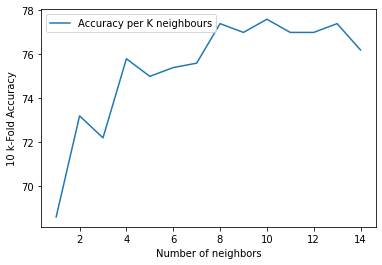

In [50]:
plt.plot(range(1,15),accuracy_list_for_each_K_neighbours)
plt.legend(['Accuracy per K neighbours'], loc='upper left')
plt.xlabel("Number of neighbors")
plt.ylabel("10 k-Fold Accuracy")
plt.show()